## Experiment Size and Statisical Power

The power of any test of statistical significance is defined as the probability that it will reject a false null hypothesis. Statistical power is inversely related to beta or the probability of making a Type II error. In short, power = 1 – β. In plain English, statistical power is the likelihood that a study will detect an effect when there is an effect there to be detected.

Consider a case where we have a baseline click-through rate of 10% and want to check that some change we have made to the website will increase this baseline click-through rate  to 12%. 

How many observations would we need in each group in order to detect this change with power $1-\beta = .80$ (i.e. detect the 2% absolute increase 80% of the time), at a Type I error rate of $\alpha = .05$?

In [3]:
# import packages

import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats import proportion as proptests
import random

import seaborn as sns
import matplotlib.pyplot as plt

### Method 1: Trial and error method to build intuition

In [4]:
def power(p_null, p_alt, n, alpha = .05, plot = True):
    """
    Compute the power of detecting the difference in two populations with 
    different proportion parameters, given a desired alpha rate.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected, must be larger than
                p_null
        n     : number of observations made in each group
        alpha : Type-I error rate
        plot  : boolean for whether or not a plot of distributions will be
                created
    
    Output value:
        power : Power to detect the desired difference, under the null.
    """
    
    # Compute the power

    
    #Calculate the standard error of the null hypothessis distribution (p1-p2=0)
    #Remember that the variance of the difference distribution is the sum of the variances..
    #for the individual distributions, and that each group is assigned n observations.    
    se_null = np.sqrt((p_null * (1-p_null) + p_null * (1-p_null)) / n)
    null_dist = stats.norm(loc = 0, scale = se_null)
    #calculate the point at which the distribution croses the alpha level
    p_crit = null_dist.ppf(1 - alpha)
    
    #Now consider the alternative hypotesis distribution.
    se_alt  = np.sqrt((p_null * (1-p_null) + p_alt  * (1-p_alt) ) / n)
    alt_dist = stats.norm(loc = p_alt - p_null, scale = se_alt)
    beta = alt_dist.cdf(p_crit)
    
    if plot:
        # Compute distribution heights
        low_bound = null_dist.ppf(.01)
        high_bound = alt_dist.ppf(.99)
        x = np.linspace(low_bound, high_bound, 201)
        y_null = null_dist.pdf(x)
        y_alt = alt_dist.pdf(x)

        # Plot the distributions
        plt.plot(x, y_null)
        plt.plot(x, y_alt)
        plt.vlines(p_crit, 0, np.amax([null_dist.pdf(p_crit), alt_dist.pdf(p_crit)]),
                   linestyles = '--')
        plt.fill_between(x, y_null, 0, where = (x >= p_crit), alpha = .5)
        plt.fill_between(x, y_alt , 0, where = (x <= p_crit), alpha = .5)
        
        plt.legend(['null','alt'])
        plt.xlabel('difference')
        plt.ylabel('density')
        plt.show()
    
    # return power
    return (1 - beta)

*An important note to consider here is that these plots are comparing the null hypothesis ($p_{1}-p_{2}=0$) verses the alternative hypothesis ($p_{1}-p_{2} \neq 0$). Therefore the standard errors used are those for comparing proportions:*

$$\sqrt{\frac{\hat{p}_{1}(1-\hat{p}_{1})}{n_{1}} + \frac{\hat{p}_{2}(1-\hat{p}_{2})}{n_{2}} }$$ 

*For the null distribution this simplifies to:*

$$\sqrt{\frac{\hat{p}_{null}(1-\hat{p}_{null}) + \hat{p}_{null}(1-\hat{p}_{null})} {n} }$$ 

*and for the alternative distribution (remember that we are plotting below the distribution of differenences in the proportions of click-throughs ($p_{1} - p_{2}$):*

$$\sqrt{\frac{\hat{p}_{null}(1-\hat{p}_{null}) + \hat{p}_{alt}(1-\hat{p}_{alt})} {n} }$$ 



#### Plot 1

Effect size of 2%  
Number of samples: 1000

The $\beta$ zone is in orange. That is, the error that occurs when one fails to reject a null hypothesis that is actually false.

If we want a power of 80% then the 1 - $\beta$ zone needs to be 80%

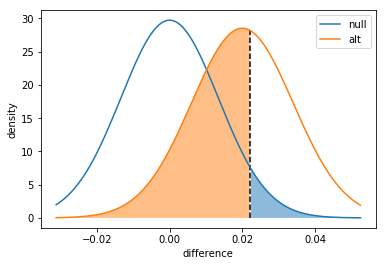

0.44122379261151545

In [5]:
power(.1, .12, 1000)

#### Plot 2

Effect size of 4%
Number of samples: 1000

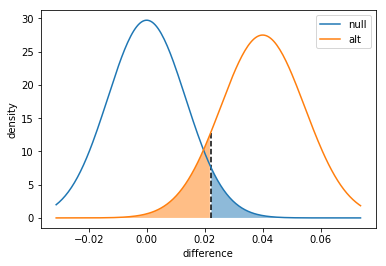

0.8918165933739692

In [6]:
power(.1, .14, 1000)

#### Plot 3

Effect size of 2%
Number of samples: 5000

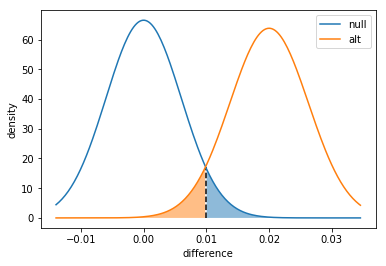

0.9473568779464357

In [9]:
power(.1, .12, 5_000)

### Method 2: Analytic Solution
    
The key point to notice is that, for an $\alpha$ and $\beta$ both < .5, the critical value for determining statistical significance will fall between our null click-through rate and our alternative, desired click-through rate. So, the difference between $p_0$ and $p_1$ can be subdivided into the distance from $p_0$ to the critical value $p^*$ and the distance from $p^*$ to $p_1$.

<img src= './images/ExpSize_Power.png'>

Those subdivisions can be expressed in terms of the standard error and the z-scores:

$$p^* - p_0 = z_{1-\alpha} SE_{0},$$
$$p_1 - p^* = -z_{\beta} SE_{1};$$

$$p_1 - p_0 = z_{1-\alpha} SE_{0} - z_{\beta} SE_{1}$$

In turn, the standard errors can be expressed in terms of the standard deviations of the distributions, divided by the square root of the number of samples in each group:

$$SE_{0} = \frac{s_{0}}{\sqrt{n}},$$
$$SE_{1} = \frac{s_{1}}{\sqrt{n}}$$

Substituting these values in and solving for $n$ will give us a formula for computing a minimum sample size to detect a specified difference, at the desired level of power:

$$n = \lceil \big(\frac{z_{\alpha} s_{0} - z_{\beta} s_{1}}{p_1 - p_0}\big)^2 \rceil$$

where $\lceil ... \rceil$ represents the ceiling function, rounding up decimal values to the next-higher integer. Implement the necessary variables in the function below, and test them with the cells that follow.    

In [10]:
def experiment_size(p_null, p_alt, alpha = .05, beta = .20):
    """
    Compute the minimum number of samples needed to achieve a desired power
    level for a given effect size.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected
        alpha : Type-I error rate
        beta  : Type-II error rate
    
    Output value:
        n : Number of samples required for each group to obtain desired power
    """
    
    # Get necessary z-scores and standard deviations (@ 1 obs per group)
    z_null = stats.norm.ppf(1 - alpha)
    z_alt  = stats.norm.ppf(beta)
    sd_null = np.sqrt(p_null * (1-p_null) + p_null * (1-p_null))
    sd_alt  = np.sqrt(p_null * (1-p_null) + p_alt  * (1-p_alt) )
    
    # Compute and return minimum sample size
    p_diff = p_alt - p_null
    n = ((z_null*sd_null - z_alt*sd_alt) / p_diff) ** 2
    return np.ceil(n)

In [11]:
experiment_size(.1, .12)

2863.0

*The result is the number of samples needed to obtain a statistical power of 0.8 and Type I error rate of $\alpha = 0.5$*

For notes on the above and alternative methods see my personal notes 'Experiment Design'